# Assignment 2
### Problem 1

Image shape: (360, 360, 3)
Grayscale shape: (360, 360)

Computing LoG responses for 50 scales...
σ range: [2, 20]

Scale-space shape: (360, 360, 50)

Detecting local maxima in scale-space...
Total blobs detected: 4611


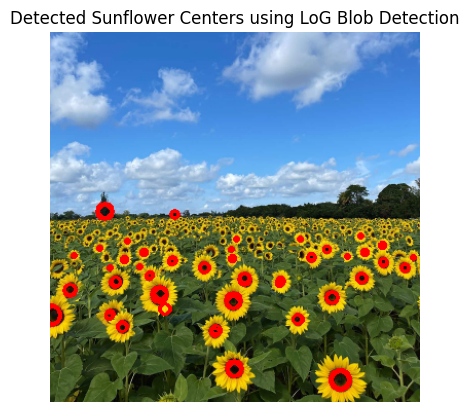


DETECTION RESULTS

σ range used: [2, 20]
Number of σ values: 50
Threshold: 0.05
Neighborhood size for local maxima: (3, 3, 2)
Total blobs detected: 4611

--------------------------------------------------------------------------------
TOP 10 LARGEST CIRCLES (by radius):
--------------------------------------------------------------------------------
Rank   X        Y        σ          Radius     Response    
--------------------------------------------------------------------------------
1      47       0        20.000     28.28      0.102926    
2      295      0        20.000     28.28      0.069862    
3      68       31       20.000     28.28      0.075601    
4      69       33       20.000     28.28      0.075608    
5      310      50       20.000     28.28      0.065867    
6      169      73       20.000     28.28      0.054688    
7      225      80       20.000     28.28      0.065898    
8      0        139      20.000     28.28      0.117758    
9      88       146      2

In [72]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter

# Read image
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray / 255.0  # Normalize

print(f"Image shape: {im.shape}")
print(f"Grayscale shape: {gray.shape}\n")

# Range of sigma values for the scale space
sigma_min = 2
sigma_max = 20
num_sigma = 50
sigma_values = np.linspace(sigma_min, sigma_max, num_sigma)

print(f"Computing LoG responses for {num_sigma} scales...")
print(f"σ range: [{sigma_min}, {sigma_max}]")

# Stack Laplacian responses across scales
log_images = []
for i, sigma in enumerate(sigma_values):
    # Compute kernel size
    size = int(2 * np.ceil(4 * sigma) + 1)
    
    # Apply Gaussian blur
    blur = cv.GaussianBlur(gray, (size, size), sigma)
    
    # Compute Laplacian
    log = cv.Laplacian(blur, cv.CV_64F, ksize=1)
    
    # Scale-normalized LoG (for scale invariance)
    log = sigma ** 2 * np.abs(log)
    
    log_images.append(log)

# Convert to 3D array (height x width x scale)
log_stack = np.stack(log_images, axis=-1)
print(f"\nScale-space shape: {log_stack.shape}")

# Find local maxima in 3D scale-space using maximum filter
print("\nDetecting local maxima in scale-space...")

# Define neighborhood size for local maxima detection
neighborhood_size = (3, 3, 2) 

# Apply maximum filter
local_max_filtered = maximum_filter(log_stack, size=neighborhood_size)

# A point is a local maximum if it equals the maximum in its neighborhood
local_maxima = (log_stack == local_max_filtered)

# Apply threshold to filter weak responses
threshold = 0.05 
threshold_mask = log_stack > threshold

# Combine conditions
blob_mask = local_maxima & threshold_mask

# Extract blob coordinates
blobs_coords = np.argwhere(blob_mask)

# Convert to (x, y, scale_idx) format
blobs = []
for coord in blobs_coords:
    y, x, scale_idx = coord
    sigma = sigma_values[scale_idx]
    response = log_stack[y, x, scale_idx]
    blobs.append((x, y, scale_idx, sigma, response))

print(f"Total blobs detected: {len(blobs)}")

# Sort by response strength
blobs_sorted = sorted(blobs, key=lambda b: b[4], reverse=True)

# Sort by size (sigma/radius)
blobs_by_size = sorted(blobs, key=lambda b: b[3], reverse=True)

# Draw circles on detected blobs
output = im.copy()

# Draw top N blobs
num_to_draw = min(100, len(blobs_sorted))
for i, (x, y, scale_idx, sigma, response) in enumerate(blobs_sorted[:num_to_draw]):
    radius = int(np.sqrt(2) * sigma)
    
    color = (0, 0, 255)
    thickness = 2
    cv.circle(output, (int(x), int(y)), radius, color, thickness)

# Display results
plt.figure(figsize=(4, 5))
plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.title(f"Detected Sunflower Centers using LoG Blob Detection")
plt.axis("off")
plt.tight_layout()
plt.savefig('sunflower_detection_result.png', dpi=150, bbox_inches='tight')
plt.show()

# Report results
print("\n" + "="*80)
print("DETECTION RESULTS")
print("="*80)
print(f"\nσ range used: [{sigma_min}, {sigma_max}]")
print(f"Number of σ values: {num_sigma}")
print(f"Threshold: {threshold}")
print(f"Neighborhood size for local maxima: {neighborhood_size}")
print(f"Total blobs detected: {len(blobs)}")

# Report top 10 largest circles
print("\n" + "-"*80)
print("TOP 10 LARGEST CIRCLES (by radius):")
print("-"*80)
print(f"{'Rank':<6} {'X':<8} {'Y':<8} {'σ':<10} {'Radius':<10} {'Response':<12}")
print("-"*80)

for i, (x, y, scale_idx, sigma, response) in enumerate(blobs_by_size[:10], 1):
    radius = np.sqrt(2) * sigma
    print(f"{i:<6} {x:<8} {y:<8} {sigma:<10.3f} {radius:<10.2f} {response:<12.6f}")

# Report parameters of the LARGEST circle
if blobs_by_size:
    x, y, scale_idx, sigma, response = blobs_by_size[0]
    radius = np.sqrt(2) * sigma
    
    print("\n" + "="*80)
    print("LARGEST CIRCLE PARAMETERS:")
    print("="*80)
    print(f"Center coordinates: ({x}, {y})")
    print(f"Sigma (σ): {sigma:.3f}")
    print(f"Radius: {radius:.2f} pixels")
    print(f"Scale index: {scale_idx}")
    print(f"LoG response: {response:.6f}")
    print("="*80)

# Report top 5 strongest responses
print("\n" + "-"*80)
print("TOP 5 STRONGEST RESPONSES:")
print("-"*80)
print(f"{'Rank':<6} {'X':<8} {'Y':<8} {'σ':<10} {'Radius':<10} {'Response':<12}")
print("-"*80)

for i, (x, y, scale_idx, sigma, response) in enumerate(blobs_sorted[:5], 1):
    radius = np.sqrt(2) * sigma
    print(f"{i:<6} {x:<8} {y:<8} {sigma:<10.3f} {radius:<10.2f} {response:<12.6f}")

print("\n" + "="*80)
print("Result saved as 'sunflower_detection_result.png'")
print("="*80)

### Problem 2

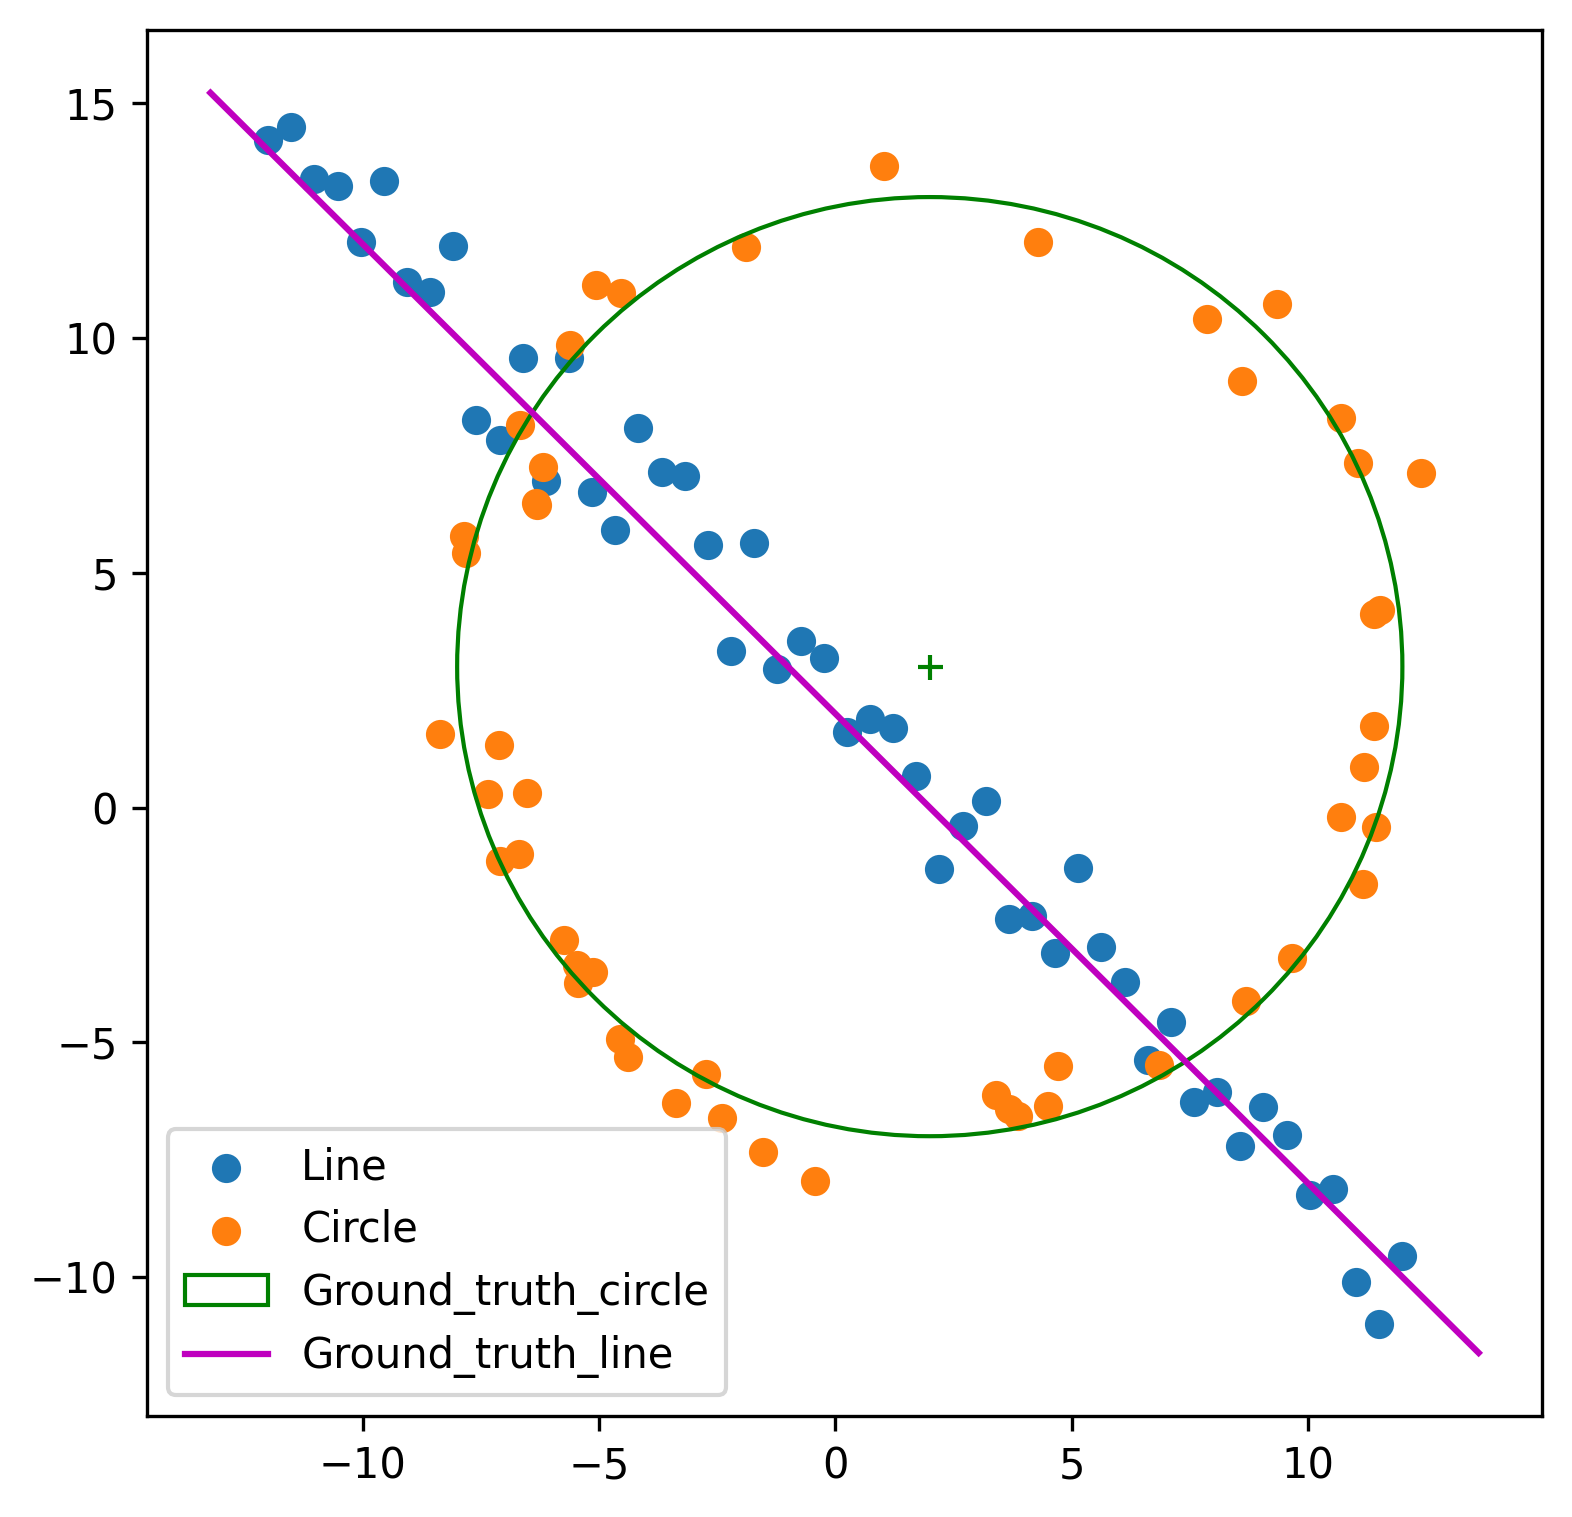

In [73]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt


np.random.seed(0)
N = 100
half_n = N // 2


r = 10
x0_gt, y0_gt = 2, 3  # Center of circle

# ---- Circle points ----
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# ---- Line points ----
s = 1.0
m, b = -1, 2  # slope and intercept
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# ---- Combine points ----
X = np.vstack((X_circ, X_line))  # All points

# ---- Plot ----

fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=300)
ax.scatter(X_line[:,0], X_line[:,1], label='Line')
ax.scatter(X_circ[:,0], X_circ[:,1], label='Circle')
circle_gt = plt.Circle((x0_gt,y0_gt), r, color='g', fill=False, label='Ground_truth_circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground_truth_line')
plt.legend()

In [25]:

def fit_line(points):
    """Fit line ax + by + d = 0 through two points."""
    (x1, y1), (x2, y2) = points
    a = y1 - y2
    b = x2 - x1
    d = -(a * x1 + b * y1)
    norm = np.sqrt(a**2 + b**2)
    return a/norm, b/norm, d/norm

def line_distance(a, b, d, X):
    """Compute normal distance from line to all points."""
    return np.abs(a*X[:,0] + b*X[:,1] + d)

def ransac_line(X, n_iter=1000, threshold=0.6, min_inliers=35):
    best_inliers = []
    best_model = None
    for _ in range(n_iter):
        sample = X[np.random.choice(len(X), 2, replace=False)]
        a, b, d = fit_line(sample)
        distances = line_distance(a, b, d, X)
        inliers = X[distances < threshold]
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = (a, b, d)
    return best_model, best_inliers


In [26]:
def fit_circle(pts):
    """Fit a circle through 3 points."""
    A = np.array([[2*(pts[1,0]-pts[0,0]), 2*(pts[1,1]-pts[0,1])],
                  [2*(pts[2,0]-pts[0,0]), 2*(pts[2,1]-pts[0,1])]])
    b = np.array([(pts[1,0]**2 - pts[0,0]**2) + (pts[1,1]**2 - pts[0,1]**2),
                  (pts[2,0]**2 - pts[0,0]**2) + (pts[2,1]**2 - pts[0,1]**2)])
    center = np.linalg.solve(A, b)
    radius = np.sqrt((pts[0,0]-center[0])**2 + (pts[0,1]-center[1])**2)
    return center, radius

def ransac_circle(X, n_iter=1000, threshold=1.5, min_inliers=45):
    best_inliers = []
    best_model = None
    for _ in range(n_iter):
        sample = X[np.random.choice(len(X), 3, replace=False)]
        try:
            center, r = fit_circle(sample)
        except np.linalg.LinAlgError:
            continue
        dist = np.sqrt((X[:,0]-center[0])**2 + (X[:,1]-center[1])**2)
        inliers = X[np.abs(dist - r) < threshold]
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = (center, r)
    return best_model, best_inliers


Estimated line: a=0.71, b=0.70, d=-1.48
Estimated circle: center =[2.12229446 2.34958527], r=9.88
Number of inliers in the line: 35
Number of inliers in the circle: 52


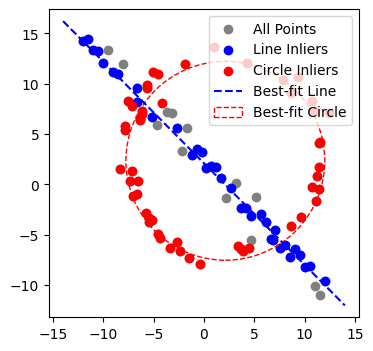

In [76]:
line_model, line_inliers = ransac_line(X)
a, b, d = line_model
circle_model, circle_inliers = ransac_circle(np.array([p for p in X if p.tolist() not in line_inliers.tolist()]))

center, r = circle_model

print(f"Estimated line: a={a:.2f}, b={b:.2f}, d={d:.2f}")
print(f"Estimated circle: center ={center}, r={r:.2f}")
print("Number of inliers in the line:", len(line_inliers))
print("Number of inliers in the circle:", len(circle_inliers))

# Plot
plt.figure(figsize=(4,4))
plt.scatter(X[:,0], X[:,1], label="All Points", c="gray")
plt.scatter(line_inliers[:,0], line_inliers[:,1], c="blue", label="Line Inliers")
plt.scatter(circle_inliers[:,0], circle_inliers[:,1], c="red", label="Circle Inliers")

x_vals = np.linspace(-14,14,100)
y_vals = (-a*x_vals - d)/b
plt.plot(x_vals, y_vals, 'b--', label="Best-fit Line")

circle = plt.Circle(center, r, color='r', fill=False, linestyle='--', label="Best-fit Circle")
plt.gca().add_patch(circle)

plt.legend()
plt.axis('equal')
plt.show()


### Problem 3

EXAMPLE: FLAG ON ARCHITECTURAL IMAGE

POINT SELECTION INSTRUCTIONS
Click 4 points on the planar surface in this order:
  1. Top-left corner
  2. Top-right corner
  3. Bottom-right corner
  4. Bottom-left corner

Press 'q' when done or 'r' to reset

Point 1: (88, 103)
Point 2: (520, 103)
Point 3: (519, 253)
Point 4: (88, 252)

Source points (flag corners):
[[  0.   0.]
 [539.   0.]
 [539. 359.]
 [  0. 359.]]

Destination points (selected on image):
[[ 88. 103.]
 [520. 103.]
 [519. 253.]
 [ 88. 252.]]

Computing homography...
Homography matrix:
[[ 7.95037744e-01  5.64935993e-04  8.80000000e+01]
 [-1.27690021e-03  4.16659554e-01  1.03000000e+02]
 [-1.23970894e-05  6.41972718e-06  1.00000000e+00]]

Warping source image...
Blending images...


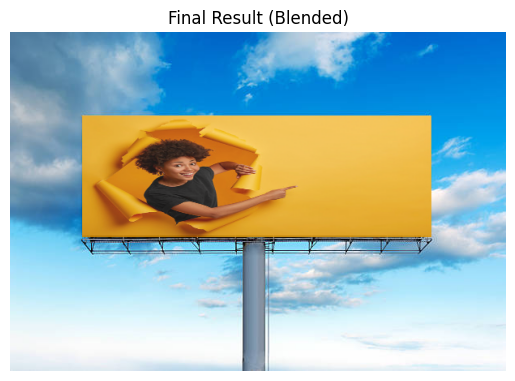


HOMOGRAPHY MATRIX:
[[ 7.95037744e-01  5.64935993e-04  8.80000000e+01]
 [-1.27690021e-03  4.16659554e-01  1.03000000e+02]
 [-1.23970894e-05  6.41972718e-06  1.00000000e+00]]

Result saved as 'homography_result.png'


True

In [81]:
dst_points = []
current_image = None
window_name = "Select Points"

def mouse_callback(event, x, y, flags, param):
    global dst_points, current_image
    
    if event == cv.EVENT_LBUTTONDOWN:
        if len(dst_points) < 4:
            dst_points.append([x, y])
            # Draw point on image
            cv.circle(current_image, (x, y), 5, (0, 255, 0), -1)
            cv.putText(current_image, str(len(dst_points)), 
                        (x + 10, y - 10), cv.FONT_HERSHEY_SIMPLEX, 
                        0.7, (0, 255, 0), 2)
            cv.imshow(window_name, current_image)
            print(f"Point {len(dst_points)}: ({x}, {y})")

def select_points_interactive(image):
    global dst_points, current_image
    
    dst_points = []
    current_image = image.copy()
    
    cv.namedWindow(window_name)
    cv.setMouseCallback(window_name, mouse_callback)
    
    print("\n" + "="*60)
    print("POINT SELECTION INSTRUCTIONS")
    print("="*60)
    print("Click 4 points on the planar surface in this order:")
    print("  1. Top-left corner")
    print("  2. Top-right corner")
    print("  3. Bottom-right corner")
    print("  4. Bottom-left corner")
    print("\nPress 'q' when done or 'r' to reset")
    print("="*60 + "\n")
    
    while True:
        cv.imshow(window_name, current_image)
        key = cv.waitKey(1) & 0xFF
        
        if key == ord('q') and len(dst_points) == 4:
            break
        elif key == ord('r'):
            dst_points = []
            current_image = image.copy()
            print("Points reset. Please select again.")
    
    cv.destroyAllWindows()
    return np.array(dst_points, dtype=np.float32)

def compute_homography(src_pts, dst_pts):
    assert src_pts.shape[0] == dst_pts.shape[0] >= 4, "Need at least 4 point pairs"
    
    n = src_pts.shape[0]
    A = []
    
    for i in range(n):
        x, y = src_pts[i]
        u, v = dst_pts[i]
        
        # Build the matrix A for homogeneous system Ah = 0
        A.append([-x, -y, -1, 0, 0, 0, u*x, u*y, u])
        A.append([0, 0, 0, -x, -y, -1, v*x, v*y, v])
    
    A = np.array(A)
    
    # Solve using SVD
    U, S, Vt = np.linalg.svd(A)
    
    # The solution is the last column of V (last row of Vt)
    H = Vt[-1].reshape(3, 3)
    
    # Normalize so that H[2,2] = 1
    H = H / H[2, 2]
    
    return H

def warp_image(src_img, H, dst_shape):
    h, w = dst_shape[:2]
    warped = np.zeros((h, w, 3), dtype=np.uint8)
    mask = np.zeros((h, w), dtype=np.uint8)
    
    # Inverse homography (maps dst to src)
    H_inv = np.linalg.inv(H)
    
    # Create mesh grid of destination coordinates
    y_coords, x_coords = np.mgrid[0:h, 0:w]
    
    # Convert to homogeneous coordinates
    ones = np.ones_like(x_coords)
    dst_coords = np.stack([x_coords, y_coords, ones], axis=-1)
    
    # Apply inverse homography
    dst_coords_flat = dst_coords.reshape(-1, 3).T
    src_coords_flat = H_inv @ dst_coords_flat
    
    # Convert from homogeneous to Cartesian
    src_x = src_coords_flat[0] / src_coords_flat[2]
    src_y = src_coords_flat[1] / src_coords_flat[2]
    
    src_x = src_x.reshape(h, w)
    src_y = src_y.reshape(h, w)
    
    # Bilinear interpolation
    src_h, src_w = src_img.shape[:2]
    
    # Find valid coordinates (within source image bounds)
    valid_mask = (src_x >= 0) & (src_x < src_w - 1) & \
                 (src_y >= 0) & (src_y < src_h - 1)
    
    # Get integer and fractional parts
    x0 = np.floor(src_x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(src_y).astype(int)
    y1 = y0 + 1
    
    # Clip to image boundaries
    x0 = np.clip(x0, 0, src_w - 1)
    x1 = np.clip(x1, 0, src_w - 1)
    y0 = np.clip(y0, 0, src_h - 1)
    y1 = np.clip(y1, 0, src_h - 1)
    
    # Fractional parts
    fx = src_x - x0
    fy = src_y - y0
    
    # Bilinear interpolation for each channel
    for c in range(3):
        wa = (1 - fx) * (1 - fy)
        wb = fx * (1 - fy)
        wc = (1 - fx) * fy
        wd = fx * fy
        
        pixel_value = (wa * src_img[y0, x0, c] +
                      wb * src_img[y0, x1, c] +
                      wc * src_img[y1, x0, c] +
                      wd * src_img[y1, x1, c])
        
        warped[:, :, c] = pixel_value
    
    mask[valid_mask] = 255
    
    return warped, mask

def blend_images(dst_img, src_warped, mask, alpha=1.0):
    result = dst_img.copy()
    mask_3channel = cv.cvtColor(mask, cv.COLOR_GRAY2BGR) / 255.0
    
    # Alpha blending
    result = (1 - alpha * mask_3channel) * result + alpha * mask_3channel * src_warped
    result = result.astype(np.uint8)
    
    return result

def process_image_pair(src_img, dst_img, dst_points=None, alpha=1.0):
    # Define source points (corners of source image)
    h_src, w_src = src_img.shape[:2]
    src_pts = np.array([
        [0, 0],           # Top-left
        [w_src-1, 0],     # Top-right
        [w_src-1, h_src-1], # Bottom-right
        [0, h_src-1]      # Bottom-left
    ], dtype=np.float32)
    
    # Get destination points
    if dst_points is None:
        dst_pts = select_points_interactive(dst_img)
    else:
        dst_pts = np.array(dst_points, dtype=np.float32)
    
    print("\nSource points (flag corners):")
    print(src_pts)
    print("\nDestination points (selected on image):")
    print(dst_pts)
    
    # Compute homography
    print("\nComputing homography...")
    H = compute_homography(src_pts, dst_pts)
    print("Homography matrix:")
    print(H)
    
    # Warp source image
    print("\nWarping source image...")
    warped, mask = warp_image(src_img, H, dst_img.shape)
    
    # Blend images
    print("Blending images...")
    result = blend_images(dst_img, warped, mask, alpha)
    
    return result, H, dst_pts, warped, mask

print("="*60)
print("EXAMPLE: FLAG ON ARCHITECTURAL IMAGE")
print("="*60)

# Load images
src_img = cv.imread('advertise.jpg')  # Flag
dst_img = cv.imread('billboard.jpg')  # Architectural image

# Check if images loaded successfully
if src_img is None or dst_img is None:
    print("Error: Could not load images. Make sure 'SriLankaFlag.jpg' and 'ship.jpg' exist.")
    exit()

# Resize if too large
max_dim = 800
h, w = dst_img.shape[:2]
if max(h, w) > max_dim:
    scale = max_dim / max(h, w)
    dst_img = cv.resize(dst_img, None, fx=scale, fy=scale)

# Process the image pair
result, H, dst_pts, warped, mask = process_image_pair(src_img, dst_img, alpha=0.9)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.title('Final Result (Blended)')
plt.axis('off')
plt.savefig('homography_result.png', dpi=150, bbox_inches='tight')
plt.show()


# Print homography matrix
print("\n" + "="*60)
print("HOMOGRAPHY MATRIX:")
print("="*60)
print(H)
print("\nResult saved as 'homography_result.png'")
print("="*60)

# Save the result
cv.imwrite('result.jpg', result)

EXAMPLE: FLAG ON ARCHITECTURAL IMAGE

POINT SELECTION INSTRUCTIONS
Click 4 points on the planar surface in this order:
  1. Top-left corner
  2. Top-right corner
  3. Bottom-right corner
  4. Bottom-left corner

Press 'q' when done or 'r' to reset

Point 1: (414, 341)
Point 2: (520, 391)
Point 3: (460, 480)
Point 4: (330, 451)

Source points (flag corners):
[[  0.   0.]
 [735.   0.]
 [735. 459.]
 [  0. 459.]]

Destination points (selected on image):
[[414. 341.]
 [520. 391.]
 [460. 480.]
 [330. 451.]]

Computing homography...
Homography matrix:
[[ 3.26324129e-01 -2.30324637e-01  4.14000000e+02]
 [ 2.04957247e-01  1.74983345e-01  3.41000000e+02]
 [ 3.50204695e-04 -1.43388184e-04  1.00000000e+00]]

Warping source image...
Blending images...


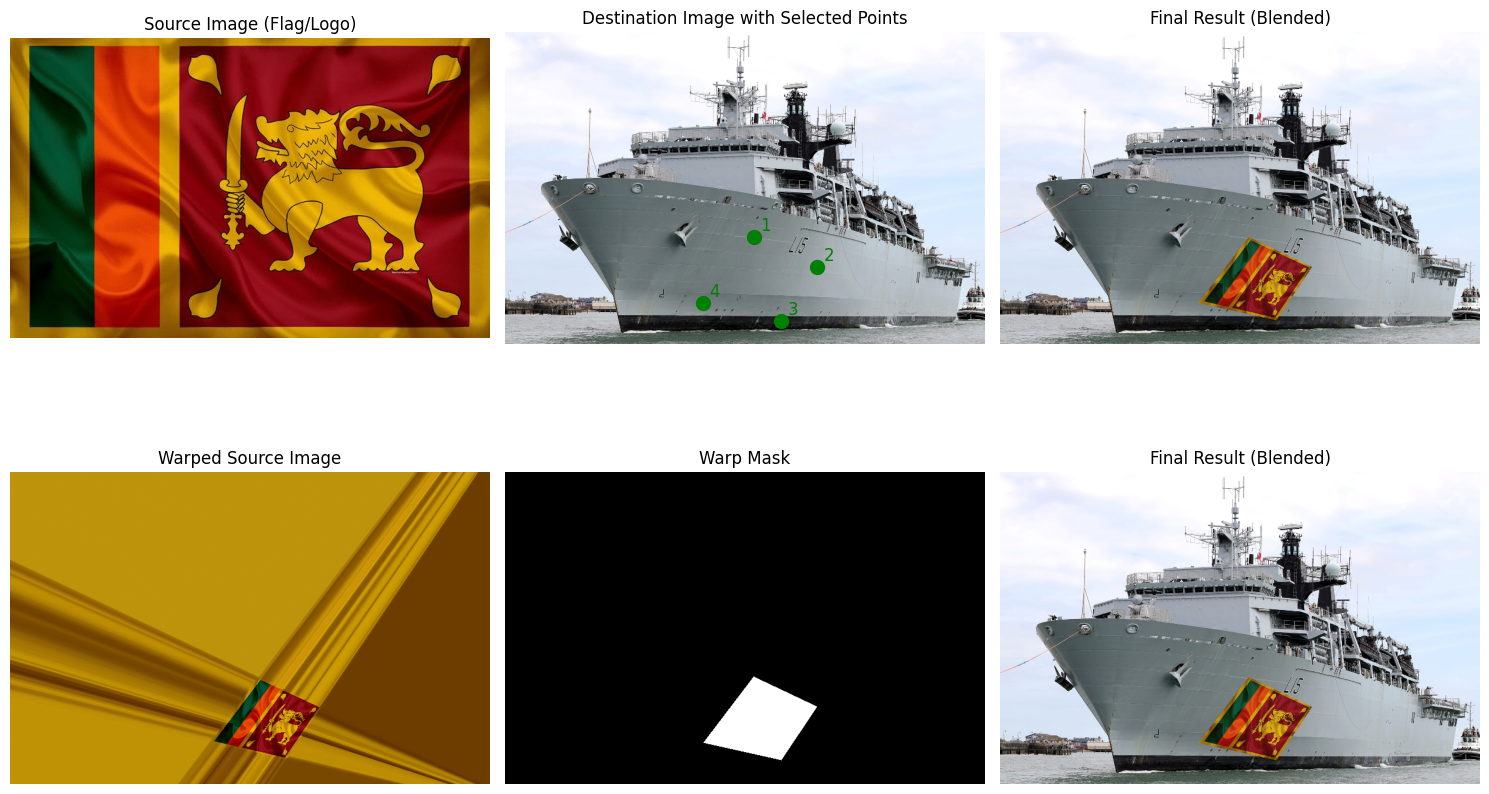


HOMOGRAPHY MATRIX:
[[ 3.26324129e-01 -2.30324637e-01  4.14000000e+02]
 [ 2.04957247e-01  1.74983345e-01  3.41000000e+02]
 [ 3.50204695e-04 -1.43388184e-04  1.00000000e+00]]

Result saved as 'homography_result.png'


True

In [87]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Global variables for mouse callback
dst_points = []
current_image = None
window_name = "Select Points"

def mouse_callback(event, x, y, flags, param):
    """Mouse callback for point selection"""
    global dst_points, current_image
    
    if event == cv.EVENT_LBUTTONDOWN:
        if len(dst_points) < 4:
            dst_points.append([x, y])
            # Draw point on image
            cv.circle(current_image, (x, y), 5, (0, 255, 0), -1)
            cv.putText(current_image, str(len(dst_points)), 
                        (x + 10, y - 10), cv.FONT_HERSHEY_SIMPLEX, 
                        0.7, (0, 255, 0), 2)
            cv.imshow(window_name, current_image)
            print(f"Point {len(dst_points)}: ({x}, {y})")

def select_points_interactive(image):
    """
    Interactive point selection on the destination image.
    Click 4 points in order: top-left, top-right, bottom-right, bottom-left
    """
    global dst_points, current_image
    
    dst_points = []
    current_image = image.copy()
    
    cv.namedWindow(window_name)
    cv.setMouseCallback(window_name, mouse_callback)
    
    print("\n" + "="*60)
    print("POINT SELECTION INSTRUCTIONS")
    print("="*60)
    print("Click 4 points on the planar surface in this order:")
    print("  1. Top-left corner")
    print("  2. Top-right corner")
    print("  3. Bottom-right corner")
    print("  4. Bottom-left corner")
    print("\nPress 'q' when done or 'r' to reset")
    print("="*60 + "\n")
    
    while True:
        cv.imshow(window_name, current_image)
        key = cv.waitKey(1) & 0xFF
        
        if key == ord('q') and len(dst_points) == 4:
            break
        elif key == ord('r'):
            dst_points = []
            current_image = image.copy()
            print("Points reset. Please select again.")
    
    cv.destroyAllWindows()
    return np.array(dst_points, dtype=np.float32)

def compute_homography(src_pts, dst_pts):
    """
    Compute homography matrix from source to destination points.
    Uses the Direct Linear Transform (DLT) method.
    """
    assert src_pts.shape[0] == dst_pts.shape[0] >= 4, "Need at least 4 point pairs"
    
    n = src_pts.shape[0]
    A = []
    
    for i in range(n):
        x, y = src_pts[i]
        u, v = dst_pts[i]
        
        # Build the matrix A for homogeneous system Ah = 0
        A.append([-x, -y, -1, 0, 0, 0, u*x, u*y, u])
        A.append([0, 0, 0, -x, -y, -1, v*x, v*y, v])
    
    A = np.array(A)
    
    # Solve using SVD
    U, S, Vt = np.linalg.svd(A)
    
    # The solution is the last column of V (last row of Vt)
    H = Vt[-1].reshape(3, 3)
    
    # Normalize so that H[2,2] = 1
    H = H / H[2, 2]
    
    return H

def warp_image(src_img, H, dst_shape):
    """
    Warp source image using homography H to destination shape.
    Uses inverse warping with bilinear interpolation.
    """
    h, w = dst_shape[:2]
    warped = np.zeros((h, w, 3), dtype=np.uint8)
    mask = np.zeros((h, w), dtype=np.uint8)
    
    # Inverse homography (maps dst to src)
    H_inv = np.linalg.inv(H)
    
    # Create mesh grid of destination coordinates
    y_coords, x_coords = np.mgrid[0:h, 0:w]
    
    # Convert to homogeneous coordinates
    ones = np.ones_like(x_coords)
    dst_coords = np.stack([x_coords, y_coords, ones], axis=-1)
    
    # Apply inverse homography
    dst_coords_flat = dst_coords.reshape(-1, 3).T
    src_coords_flat = H_inv @ dst_coords_flat
    
    # Convert from homogeneous to Cartesian
    src_x = src_coords_flat[0] / src_coords_flat[2]
    src_y = src_coords_flat[1] / src_coords_flat[2]
    
    src_x = src_x.reshape(h, w)
    src_y = src_y.reshape(h, w)
    
    # Bilinear interpolation
    src_h, src_w = src_img.shape[:2]
    
    # Find valid coordinates (within source image bounds)
    valid_mask = (src_x >= 0) & (src_x < src_w - 1) & \
                 (src_y >= 0) & (src_y < src_h - 1)
    
    # Get integer and fractional parts
    x0 = np.floor(src_x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(src_y).astype(int)
    y1 = y0 + 1
    
    # Clip to image boundaries
    x0 = np.clip(x0, 0, src_w - 1)
    x1 = np.clip(x1, 0, src_w - 1)
    y0 = np.clip(y0, 0, src_h - 1)
    y1 = np.clip(y1, 0, src_h - 1)
    
    # Fractional parts
    fx = src_x - x0
    fy = src_y - y0
    
    # Bilinear interpolation for each channel
    for c in range(3):
        wa = (1 - fx) * (1 - fy)
        wb = fx * (1 - fy)
        wc = (1 - fx) * fy
        wd = fx * fy
        
        pixel_value = (wa * src_img[y0, x0, c] +
                      wb * src_img[y0, x1, c] +
                      wc * src_img[y1, x0, c] +
                      wd * src_img[y1, x1, c])
        
        warped[:, :, c] = pixel_value
    
    mask[valid_mask] = 255
    
    return warped, mask

def blend_images(dst_img, src_warped, mask, alpha=1.0):
    """
    Blend warped source image onto destination image.
    """
    result = dst_img.copy()
    mask_3channel = cv.cvtColor(mask, cv.COLOR_GRAY2BGR) / 255.0
    
    # Alpha blending
    result = (1 - alpha * mask_3channel) * result + alpha * mask_3channel * src_warped
    result = result.astype(np.uint8)
    
    return result

def process_image_pair(src_img, dst_img, dst_points=None, alpha=1.0):
    """
    Complete pipeline: select points, compute homography, warp, and blend.
    """
    # Define source points (corners of source image)
    h_src, w_src = src_img.shape[:2]
    src_pts = np.array([
        [0, 0],           # Top-left
        [w_src-1, 0],     # Top-right
        [w_src-1, h_src-1], # Bottom-right
        [0, h_src-1]      # Bottom-left
    ], dtype=np.float32)
    
    # Get destination points
    if dst_points is None:
        dst_pts = select_points_interactive(dst_img)
    else:
        dst_pts = np.array(dst_points, dtype=np.float32)
    
    print("\nSource points (flag corners):")
    print(src_pts)
    print("\nDestination points (selected on image):")
    print(dst_pts)
    
    # Compute homography
    print("\nComputing homography...")
    H = compute_homography(src_pts, dst_pts)
    print("Homography matrix:")
    print(H)
    
    # Warp source image
    print("\nWarping source image...")
    warped, mask = warp_image(src_img, H, dst_img.shape)
    
    # Blend images
    print("Blending images...")
    result = blend_images(dst_img, warped, mask, alpha)
    
    return result, H, dst_pts, warped, mask

print("="*60)
print("EXAMPLE: FLAG ON ARCHITECTURAL IMAGE")
print("="*60)

# Load images
src_img = cv.imread('SriLankaFlag.jpg')  # Flag
dst_img = cv.imread('ship.jpg')  # Architectural image

# Check if images loaded successfully
if src_img is None or dst_img is None:
    print("Error: Could not load images. Make sure 'SriLankaFlag.jpg' and 'ship.jpg' exist.")
    exit()

# Resize if too large
max_dim = 800
h, w = dst_img.shape[:2]
if max(h, w) > max_dim:
    scale = max_dim / max(h, w)
    dst_img = cv.resize(dst_img, None, fx=scale, fy=scale)

# Process the image pair
result, H, dst_pts, warped, mask = process_image_pair(src_img, dst_img, alpha=0.9)

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(cv.cvtColor(src_img, cv.COLOR_BGR2RGB))
axes[0, 0].set_title('Source Image (Flag/Logo)')
axes[0, 0].axis('off')

axes[0, 1].imshow(cv.cvtColor(dst_img, cv.COLOR_BGR2RGB))
# Draw selected points
for i, pt in enumerate(dst_pts, 1):
    axes[0, 1].plot(pt[0], pt[1], 'go', markersize=10)
    axes[0, 1].text(pt[0]+10, pt[1]-10, str(i), color='green', fontsize=12)
axes[0, 1].set_title('Destination Image with Selected Points')
axes[0, 1].axis('off')

axes[0, 2].imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
axes[0, 2].set_title('Final Result (Blended)')
axes[0, 2].axis('off')

axes[1, 0].imshow(cv.cvtColor(warped, cv.COLOR_BGR2RGB))
axes[1, 0].set_title('Warped Source Image')
axes[1, 0].axis('off')

axes[1, 1].imshow(mask, cmap='gray')
axes[1, 1].set_title('Warp Mask')
axes[1, 1].axis('off')

axes[1, 2].imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
axes[1, 2].set_title('Final Result (Blended)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('homography_result.png', dpi=150, bbox_inches='tight')
plt.show()

# Print homography matrix
print("\n" + "="*60)
print("HOMOGRAPHY MATRIX:")
print("="*60)
print(H)
print("\nResult saved as 'homography_result.png'")
print("="*60)

# Save the result
cv.imwrite('result.jpg', result)

### Problem 4

In [82]:
def compute_sift_matches(img1, img2):
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # FLANN-based matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    print(f"Number of good matches: {len(good_matches)}")
    return kp1, kp2, good_matches

def ransac_homography(kp1, kp2, matches, threshold=5.0, iterations=2000):
    if len(matches) < 4:
        raise ValueError("Not enough matches to compute homography")

    best_H = None
    max_inliers = 0
    best_inliers_mask = None

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    for _ in range(iterations):
        # Randomly pick 4 correspondences
        idx = np.random.choice(len(matches), 4, replace=False)
        H, _ = cv.findHomography(pts1[idx], pts2[idx], 0)  # 0 = Direct Linear Transform (DLT)
        if H is None:
            continue
        
        
        # Transform points using H
        pts1_h = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
        pts2_proj = (H @ pts1_h.T).T
        pts2_proj = pts2_proj[:, :2] / pts2_proj[:, 2, np.newaxis]

        # Compute errors
        errors = np.linalg.norm(pts2 - pts2_proj, axis=1)
        inliers = errors < threshold
        num_inliers = np.sum(inliers)

        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H
            best_inliers_mask = inliers

    print(f"RANSAC: {max_inliers} inliers found")
    return best_H, best_inliers_mask

def stitch_images(img1, img2, H):
    # Warp img1 into img2 coordinate frame
    h2, w2 = img2.shape[:2]
    h1, w1 = img1.shape[:2]

    corners_img1 = np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1,1,2)
    warped_corners = cv.perspectiveTransform(corners_img1, H)
    all_corners = np.vstack((warped_corners, np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)))

    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel())
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel())

    translation = [-xmin, -ymin]
    H_translate = np.array([[1, 0, translation[0]], [0, 1, translation[1]], [0, 0, 1]])

    result = cv.warpPerspective(img1, H_translate @ H, (xmax - xmin, ymax - ymin))
    result[translation[1]:h2+translation[1], translation[0]:w2+translation[0]] = img2
    return result

Number of good matches: 105
RANSAC: 7 inliers found
[[ 8.31135179e-02 -5.67935192e-01  1.49561305e+02]
 [-5.38458934e-02 -1.38303901e+00  4.04612908e+02]
 [ 1.02580987e-04 -3.47814642e-03  1.00000000e+00]]


C:\Users\hansa\AppData\Local\Temp\ipykernel_7052\3169699341.py:44: RuntimeWarning: invalid value encountered in divide
  pts2_proj = pts2_proj[:, :2] / pts2_proj[:, 2, np.newaxis]
C:\Users\hansa\AppData\Local\Temp\ipykernel_7052\3169699341.py:44: RuntimeWarning: divide by zero encountered in divide
  pts2_proj = pts2_proj[:, :2] / pts2_proj[:, 2, np.newaxis]


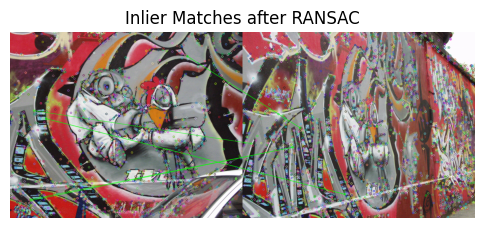

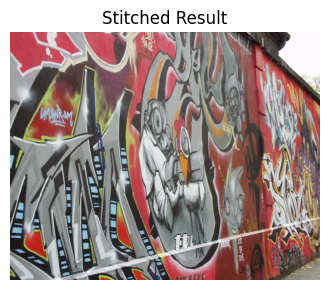

✅ Stitched image saved as stitched_result.png


In [85]:
img1 = cv.imread('graf/img1.ppm')
img2 = cv.imread('graf/img5.ppm')

kp1, kp2, good_matches = compute_sift_matches(img1, img2)

H, inliers_mask = ransac_homography(kp1, kp2, good_matches)
print(H)
# Visualize matches
matches_img = cv.drawMatches(img1, kp1, img2, kp2, good_matches, None,
                                matchColor=(0,255,0), singlePointColor=None,
                                matchesMask=inliers_mask.astype(int).tolist() if inliers_mask is not None else None)
plt.figure(figsize=(6,7))
plt.imshow(cv.cvtColor(matches_img, cv.COLOR_BGR2RGB))
plt.title("Inlier Matches after RANSAC")
plt.axis('off')
plt.show()

stitched = stitch_images(img1, img2, H)
plt.figure(figsize=(4,4))
plt.imshow(cv.cvtColor(stitched, cv.COLOR_BGR2RGB))
plt.title("Stitched Result")
plt.axis('off')
plt.show()

cv.imwrite("stitched_result.png", stitched)
print("✅ Stitched image saved as stitched_result.png")


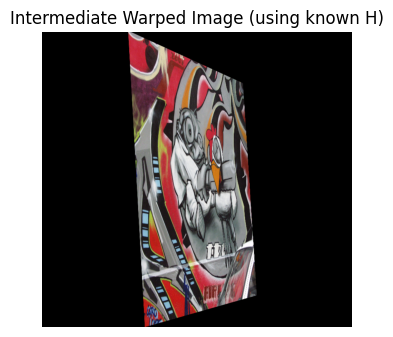

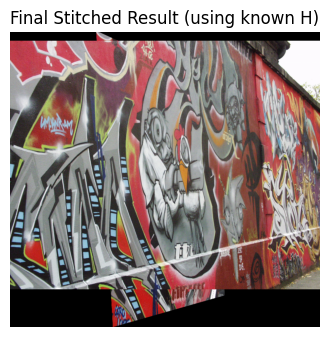

✅ Saved: warped_intermediate.png and stitched_result_knownH.png


In [86]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# --- Load the two images ---
img1 = cv.imread('graf/img1.ppm')  # image to warp
img2 = cv.imread('graf/img5.ppm')  # reference image

if img1 is None or img2 is None:
    raise FileNotFoundError("⚠️ Please make sure 'graf/img1.ppm' and 'graf/img5.ppm' exist.")

# --- Define the known homography matrix ---
H = np.array([
    [0.62544644, 0.057759174, 222.01217],
    [0.22240536, 1.1652147,  -25.605611],
    [0.00049212545, -0.000036542424, 1.0]
])

# --- Warp img1 into the coordinate frame of img2 ---
h2, w2 = img2.shape[:2]
h1, w1 = img1.shape[:2]

# Compute canvas for both images
corners_img1 = np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1,1,2)
warped_corners = cv.perspectiveTransform(corners_img1, H)
all_corners = np.vstack((warped_corners,
                         np.float32([[0,0], [0,h2], [w2,h2], [w2,0]]).reshape(-1,1,2)))

[xmin, ymin] = np.int32(all_corners.min(axis=0).ravel())
[xmax, ymax] = np.int32(all_corners.max(axis=0).ravel())

translation = [-xmin, -ymin]
H_translate = np.array([
    [1, 0, translation[0]],
    [0, 1, translation[1]],
    [0, 0, 1]
])

# --- Warped image (intermediate visualization) ---
warped_img1 = cv.warpPerspective(img1, H_translate @ H, (xmax - xmin, ymax - ymin))

plt.figure(figsize=(4, 4))
plt.imshow(cv.cvtColor(warped_img1, cv.COLOR_BGR2RGB))
plt.title("Intermediate Warped Image (using known H)")
plt.axis('off')
plt.show()

# --- Combine images (stitched result) ---
stitched = warped_img1.copy()
stitched[translation[1]:h2+translation[1], translation[0]:w2+translation[0]] = img2

plt.figure(figsize=(4, 4))
plt.imshow(cv.cvtColor(stitched, cv.COLOR_BGR2RGB))
plt.title("Final Stitched Result (using known H)")
plt.axis('off')
plt.show()

# --- Save results ---
cv.imwrite("warped_intermediate.png", warped_img1)
cv.imwrite("stitched_result_knownH.png", stitched)
print("✅ Saved: warped_intermediate.png and stitched_result_knownH.png")
